In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm, ks_2samp
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import PchipInterpolator
from scipy.special import gammaln
from scipy.optimize import minimize

import numdifftools as ndt

import dynesty
from dynesty import plotting as dyplot


from astropy.table import Table
from scipy import stats

mpl.rc('font', size=16)

In [3]:
data = Table.read('../data_flags.dat', format = 'ascii')

In [4]:
#stellar mass
Mstar = np.array(data['Mstar'])
Mstar_NSA= np.array(data['Mstar_NSA'])
# color
u_r = np.array(data['u_r'])
g_r = np.array(data['g_r'])
u_r_NSA = np.array(data['u_r_NSA'])
g_r_NSA = np.array(data['g_r_NSA'])
# absolute magniture
rabsmag = np.array(data['rabsmag'])
rabsmag_NSA = np.array(data['rabsmag_NSA'])
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
sSFR = np.array(data['sSFR'])

In [5]:
#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

In [6]:
def remove_nan(array):
    return array[np.logical_not(np.isnan(array))]

data1 = remove_nan(u_r[wall_vf])
data2 = remove_nan(u_r[void_vf])
bins_ = np.linspace(0,4, 250)

Histogram the data (left) and show normalized histograms (right).

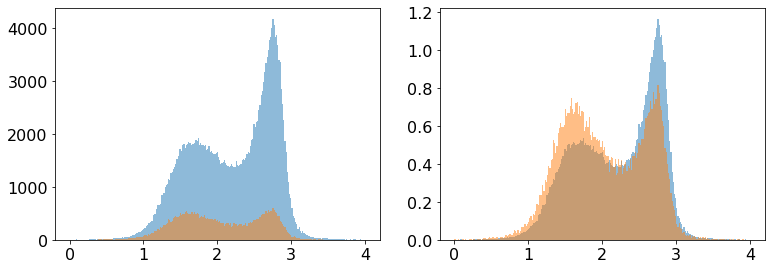

In [7]:
fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, tight_layout=True)

ax = axes[0]
ax.hist(data1, bins=bins_, alpha=0.5)
ax.hist(data2, bins=bins_, alpha=0.5)

ax = axes[1]
ax.hist(data1, bins=bins_, alpha=0.5, density=True)
ax.hist(data2, bins=bins_, alpha=0.5, density=True);

### Create Binned Data Sets

Histogram the sets to create two binned data sets used for fitting below.

<ErrorbarContainer object of 3 artists>

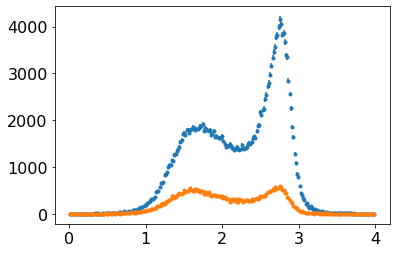

In [8]:
density = False

n1, edges1 = np.histogram(data1, bins=bins_)
dn1 = np.sqrt(n1)
x = 0.5*(edges1[1:] + edges1[:-1])
if density:
    N1 = np.trapz(n1, x1)
    n1, dn1 = n1/N1, dn1/N1
plt.errorbar(x, n1, yerr=dn1, fmt='.')

n2, edges2 = np.histogram(data2, bins=bins_)
dn2 = np.sqrt(n2)
# x = 0.5*(edges2[1:] + edges2[:-1])
if density:
    N2 = np.trapz(n2, x2)
    n2, dn2 = n2/N2, dn2/N2
plt.errorbar(x, n2, yerr=dn2, fmt='.')

### KS Test

Apply the KS test just to see what the result looks like.

In [9]:
ks, p = ks_2samp(data1, data2)
ks, p

(0.1347316755581539, 0.0)

In [10]:
def mixturemodel(params, x):
    """Mixture of two Gaussians.
    
    Parameters
    ----------
    params : list or ndarray
        List of parameters (expect 2x3).
    x : float or ndarray
        Values to calculate the model.
    
    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """
    a, mu_a, sigma_a = params[:3]
    b, mu_b, sigma_b = params[3:]
    return a*norm.pdf(x, loc=mu_a, scale=sigma_a) + b*norm.pdf(x, loc=mu_b, scale=sigma_b)

def logLjoint1(params, m, n, x):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 7 parameters: 2x3 Gaussian pars + scale factor.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """
    s, gausspars = params[0], params[1:]
    lambda1 = mixturemodel(gausspars, x)
    lambda2 = s*lambda1
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))

def nlogLjoint1(params, m, n, x):
    """Negative log-likelihood, for minimizers."""
    return -logLjoint1(params, m, n, x)

In [11]:
nlogLjoint1([4, 1800, 1.5, 2, 3800, 2.5, 1], n1,n2,x) 

1104501.2404344797

#### Maxmize the Likelihood

Find the maximum likelihood parameters of model $\mathcal{M}_1$ by minimizing $-\ln{\mathcal{L}}$.

Perform a bounded fit using the L-BFGS-B algorithm.

In [12]:
# Parameter bounds.
bounds1 = [[0.1,10.],      # s ........ Gaussian 1 to 2 scale factor
           [100., 5000.],  # a ........ Gaussian 1 amplitude
           [0., 2.],      # mu_a ..... Gaussian 1 location
           [0.1, 3.],      # sigma_a .. Gaussian 1 scale
           [100., 5000.],  # b ........ Gaussian 2 amplitude
           [2., 4.],       # mu_b ..... Gaussian 2 location
           [0.1, 3.]]      # sigma_b .. Gaussian 2 scale

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

for i in range(10):
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1]
    result = minimize(nlogLjoint1, p0, method='L-BFGS-B', args=(n1, n2, x), bounds=bounds1)
    
    if result.success:
        print(p0)
        print('  {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result

bestfit

[5.7962584618422195, 2638.0828461531655, 0.535083252341418, 0.5299124799891943, 2562.4859199712205, 2.403385934948105, 2.819990940221809]
  7023.32
[5.26734960260389, 4882.287466788861, 1.653133362686062, 1.9958634166609446, 3743.235012772596, 2.3915114771877986, 2.0315641379853786]
  43323.80
[2.5146837976933694, 4214.6994022611825, 0.8219757005758304, 1.3090208637538827, 4653.651331078121, 2.0170922306768446, 2.0037470018214276]
  43323.80
[3.7053620847538093, 3361.605763552048, 0.7160659874160762, 2.1845640868885052, 2141.2581854140503, 2.095969737218468, 0.6857229555492205]
  56959.15
[7.2910388904065195, 785.8886588555688, 1.2453823084818954, 2.2356456360712644, 4746.096895541208, 2.6310914675256782, 1.0945998820153986]
  43323.80
[6.767061739617575, 2257.6487782251656, 0.4538611655307452, 1.802642241073988, 2820.45655413776, 3.5611329589207785, 1.4100984557292449]
  43323.80
[6.678266839550035, 4648.430373909666, 1.9110553902152594, 0.9436147034909603, 2116.1685557385263, 2.16933

      fun: 7023.3200399344205
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.25352482e+00, -1.81898940e-03,  2.32803359e+00, -7.47058948e-01,
       -4.27462510e-03,  2.41125235e+00,  4.86070348e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 720
      nit: 65
   status: 0
  success: True
        x: array([2.04202369e-01, 2.33134231e+03, 1.89112280e+00, 4.76077989e-01,
       1.24360758e+03, 2.73198607e+00, 1.48682236e-01])

#### Plot Maximum Likelihood Fit

Plot the best fit results on top of the binned data.

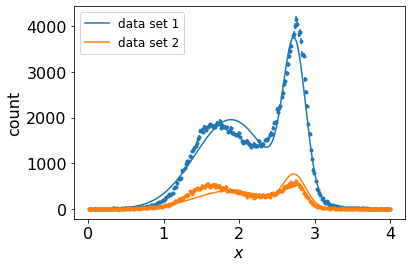

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ep = ax.errorbar(x, n1, yerr=dn1, fmt='.')
ax.plot(x, mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 1')

ep = ax.errorbar(x, n2, yerr=dn1, fmt='.');
ax.plot(x, bestfit.x[0]*mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 2')

ax.set(#xlim=(-3,3),
       xlabel='$x$',
       #ylim=(0, 1300),
       ylabel='count')

ax.legend(fontsize=12);

#### Residuals

No handles with labels found to put in legend.


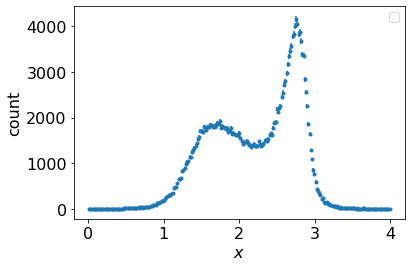

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ep = ax.errorbar(x, n1, yerr=dn1, fmt='.')
# ax.plot(x, mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 1')

# ep = ax.errorbar(x, n2, yerr=dn1, fmt='.');
# ax.plot(x, bestfit.x[0]*mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 2')

ax.set(#xlim=(-3,3),
       xlabel='$x$',
       #ylim=(0, 1300),
       ylabel='count')

ax.legend(fontsize=12);

In [24]:
ax.plot(x, n1)

In [26]:
n1

array([   0,    1,    1,    0,    4,    7,    4,    5,    1,    5,    3,
          3,    5,    4,    1,    5,    6,    8,    7,    7,   11,   11,
          5,   10,    6,    7,    8,   10,    7,   18,   19,   15,   23,
         19,   21,   20,   20,   25,   26,   28,   32,   40,   29,   38,
         53,   34,   46,   46,   56,   45,   45,   77,   77,   90,   88,
        100,  126,  127,  142,  151,  170,  185,  197,  226,  262,  278,
        316,  314,  328,  355,  459,  479,  485,  577,  651,  665,  672,
        836,  850,  889,  994, 1039, 1045, 1149, 1135, 1260, 1288, 1342,
       1380, 1438, 1531, 1584, 1705, 1719, 1677, 1790, 1800, 1724, 1790,
       1806, 1848, 1835, 1793, 1810, 1803, 1834, 1875, 1867, 1916, 1779,
       1828, 1791, 1784, 1761, 1783, 1693, 1713, 1765, 1652, 1671, 1640,
       1622, 1613, 1630, 1661, 1564, 1497, 1433, 1454, 1460, 1497, 1446,
       1413, 1398, 1365, 1393, 1427, 1384, 1374, 1381, 1482, 1418, 1384,
       1410, 1426, 1498, 1517, 1498, 1544, 1621, 16

In [28]:
negloglike1 = lambda params: nlogLjoint1(params, n1, n2, x)

hessian = ndt.Hessian(negloglike1)
h = hessian(bestfit.x)

# Invert the Hessian matrix and compute the square root of the diagonals.
hinv = np.linalg.inv(h)
uncertainty = np.sqrt(np.diag(hinv))

/Users/Fatima/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log
/Users/Fatima/opt/anaconda3/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/Fatima/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/Fatima/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/Fatima/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [29]:

labels = ['$s$', '$a$', r'$\mu_a$', r'$\sigma_a$', '$b$', r'$\mu_b$', r'$\sigma_b$']
for i in range(7):
    print('{:<10s} = {:7.2f} +- {:.2f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

$s$        =    0.20 +- 0.00
$a$        = 2331.31 +- 7.98
$\mu_a$    =    1.89 +- 0.00
$\sigma_a$ =    0.48 +- 0.00
$b$        = 1243.70 +- 6.80
$\mu_b$    =    2.73 +- 0.00
$\sigma_b$ =    0.15 +- 0.00


In [52]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xform1(u):
    """Priors for the 7 parameters of model M1. Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
#     s       = uniform(0.1, 2., u[0])
#     a       = jeffreys(1., 1e4, u[1])
#     mu_a    = uniform(0., 3., u[2])
#     sigma_a = jeffreys(0.1, 1., u[3])
#     b       = jeffreys(1., 1e4, u[4])
#     mu_b    = uniform(1, 4., u[5])
#     sigma_b = jeffreys(0., 1., u[6])

    s       = uniform(0.2, 2., u[0])
    a       = jeffreys(1., 1e4, u[1])
    mu_a    = uniform(0, 3., u[2])
    sigma_a = jeffreys(0.1, 1., u[3])
    b       = jeffreys(1., 1e4, u[4])
    mu_b    = uniform(0., 3., u[5])
    sigma_b = jeffreys(0.1, 1., u[6])

#     s       = uniform(0.1, 2., u[0])
#     a       = jeffreys(1., 1e4, u[1])
#     mu_a    = uniform(0, 3., u[2])
#     sigma_a = jeffreys(0.1, 1., u[3])
#     b       = jeffreys(1., 1e4, u[4])
#     mu_b    = uniform(1, 4., u[5])
#     sigma_b = jeffreys(0., 1., u[6])
    
    return s, a, mu_a, sigma_a, b, mu_b, sigma_b

In [53]:
dsampler = dynesty.DynamicNestedSampler(logLjoint1, prior_xform1, ndim=7,
                                        logl_args=(n1, n2, x),
                                        nlive=1000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

39584it [12:31, 52.70it/s, batch: 8 | bound: 329 | nc: 1 | ncall: 293462 | eff(%): 13.489 | loglstar: -7031.807 < -7023.763 < -7025.972 | logz: -7068.226 +/-  0.399 | stop:  0.869]           


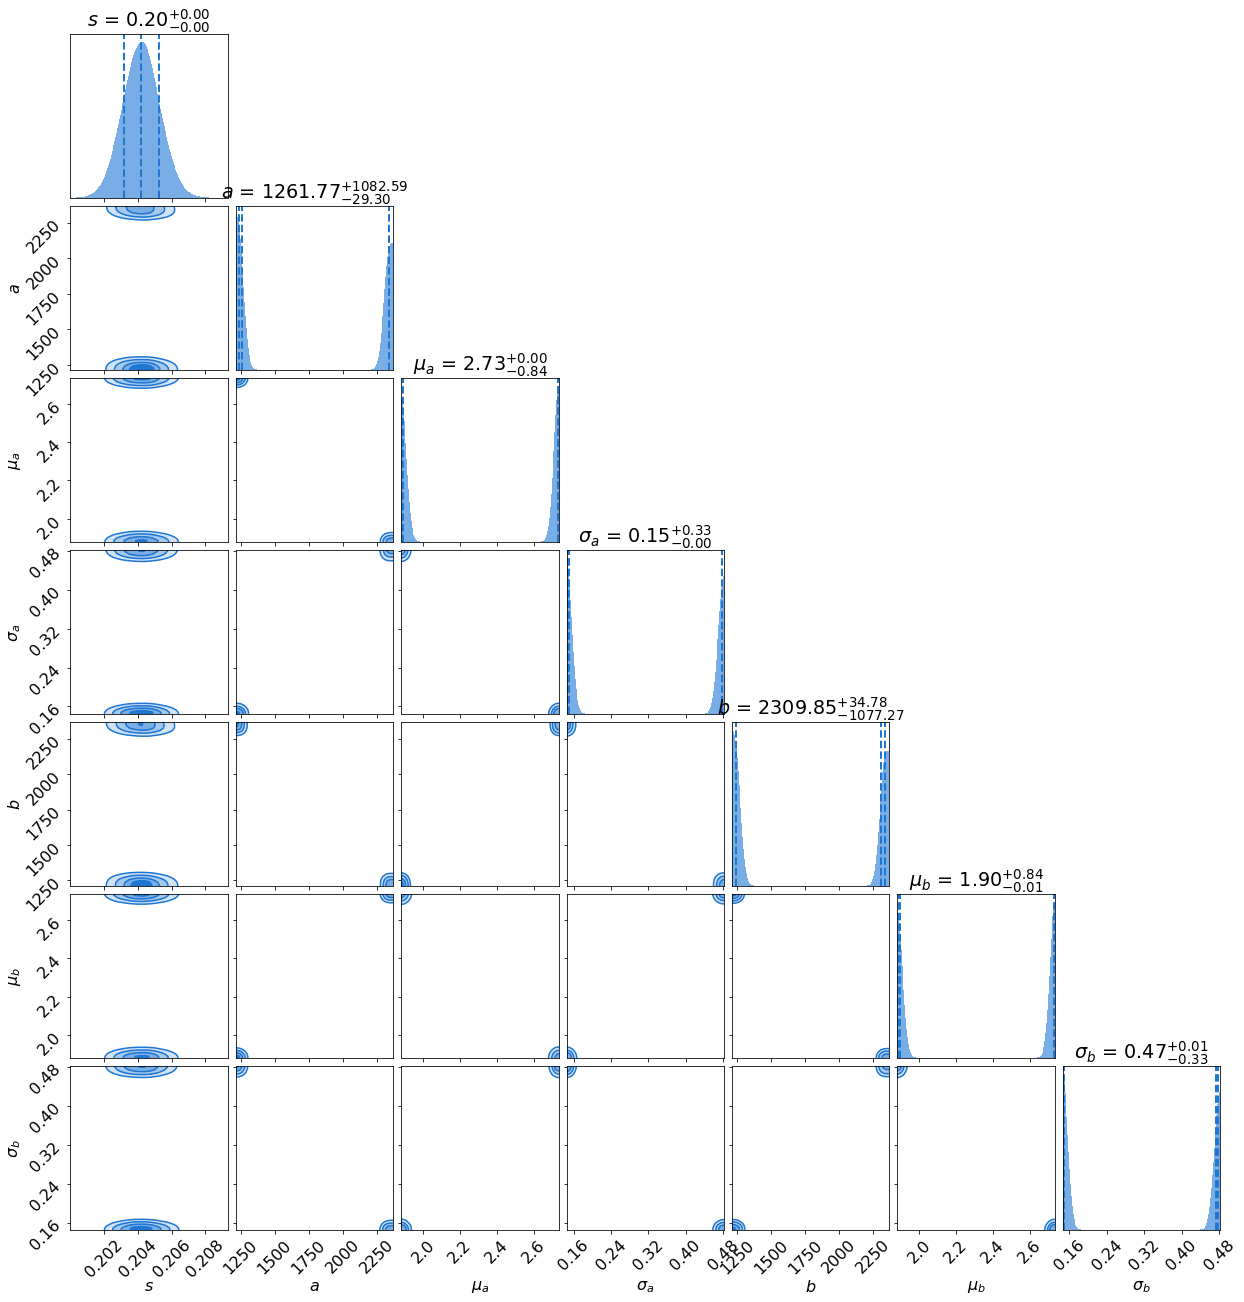

In [57]:
fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
#                               quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(7, 7, figsize=(2.5*7,2.6*7)),
                              color='#1f77d4')

In [56]:
lnzM1 = dres1.logz[-1]
lnzM1

-7068.206841655961